# NMF model with burst 
In this notebook I will check that the SFH are sensible and integrate to 1. I will check that the average SSFR does not exceed $1/dt$

In [1]:
import numpy as np 
from provabgs import infer as Infer
from provabgs import models as Models

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
Mnmf = Models.FSPS(name='nmfburst') # NMF with burst model

In [4]:
zred = 0.01
tage = Mnmf.cosmo.age(zred).value

In [5]:
prior = Infer.load_priors([
    Infer.UniformPrior(0., 0.), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1.), # fburst
    Infer.UniformPrior(0., tage), # tburst 
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

## Check SFH sensibility


In [6]:
np.random.seed(0)

In [7]:
_theta = prior.sample()
theta = prior.transform(_theta)
print(theta)
print(np.sum(theta[1:5]))
print('fburst = %.2f' % theta[5])
print('tburst = %.2f' % theta[6])

[ 0.00000000e+00  6.28301013e-01  2.84613601e-01  2.60988973e-03
  8.44754960e-02  4.90157052e-01  1.33208552e+01  2.50556311e-03
  5.88826050e-03  5.03880052e-01  9.33029911e-01 -1.48696713e+00]
1.0
fburst = 0.49
tburst = 13.32


In [8]:
t, sfh = Mnmf.SFH(theta, zred)

(0.0, 13.653058838303744)

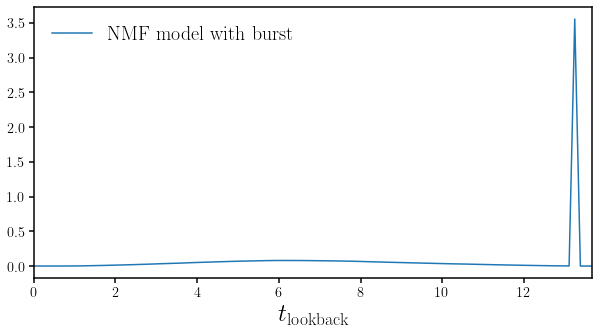

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(t, sfh, label=r'NMF model with burst')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., tage)

## check SFH normalization

In [10]:
for i in range(100): 
    _theta = prior.sample()
    theta = prior.transform(_theta)
    t, sfh = Mnmf.SFH(theta, zred)
    assert np.abs(np.trapz(sfh, t) - 1) < 1e-4, ('int(SFH) = %f' % np.trapz(sfh, t))

## check average SFR calculation 

In [11]:
_thetas = np.array([prior.sample() for i in range(50000)])
thetas = prior.transform(_thetas)
avgsfr = Mnmf.avgSFR(thetas, zred, dt=1)

In [12]:
print(avgsfr.max())

9.999017091666058e-10


(-13.0, -7.0)

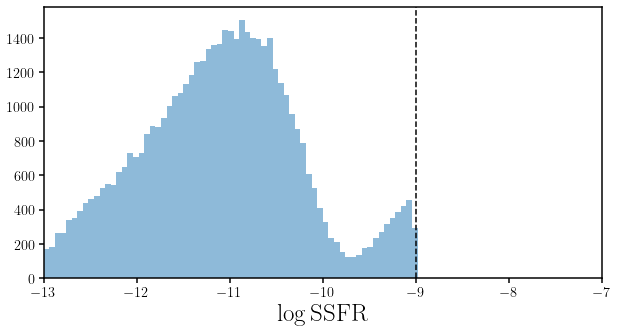

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.hist(np.log10(avgsfr), range=(-13, -7), bins=100, alpha=0.5)
sub.axvline(-9, color='k', linestyle='--')
sub.set_xlabel(r'$\log{\rm SSFR}$', fontsize=25)
sub.set_xlim(-13., -7.)